# Decision Trees

We will use ``scikit-learn`` for model building and testing. Please run the following codes to install the latest version of ``scikit-learn`` (i.e., version 1.7.2). 

```python
>>>pip install scikit-learn --upgrade
```

To learn more, click [here](https://scikit-learn.org/stable/modules/tree.html) for the `tree` module and [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for the `DecisionTreeClassifier` function.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score    

## 1. Entropy and Information Gain 

The [mushroom dataset](http://archive.ics.uci.edu/dataset/73/mushroom) contains 8124 gilled mushrooms in the Agaricus and Lepiota Family.    Each row is a mushroom (instance) and each column is an attribute/variable. 

- 22 features. 
- 1 target variable: `edible` which takes on two classes - `e` (edible) or `p` (poisonous).

**We'd like to calculate the information gain for a feature (e.g.,  ``gillcolor``).**

In [16]:
mushroom = pd.read_csv('mushroom.csv',sep = ' ')    # note the separater

display(mushroom.shape, mushroom.columns, mushroom.head())

(8124, 23)

Index(['edible', 'capshape', 'capsurface', 'capcolor', 'bruises', 'odor',
       'gillattachment', 'gillspacing', 'gillsize', 'gillcolor', 'stalkshape',
       'stalkroot', 'stalksurfaceabovering', 'stalksurfacebelowring',
       'stalkcolorabovering', 'stalkcolorbelowring', 'veiltype', 'veilcolor',
       'ringnumber', 'ringtype', 'sporeprintcolor', 'population', 'habitat'],
      dtype='object')

,edible,capshape,capsurface,capcolor,bruises,odor,gillattachment,gillspacing,gillsize,gillcolor,...,stalksurfacebelowring,stalkcolorabovering,stalkcolorbelowring,veiltype,veilcolor,ringnumber,ringtype,sporeprintcolor,population,habitat
1,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
2,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
3,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
4,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
5,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


<font color=green>***Notes for Google Colab***</font>

for Google Colab users, please (1) save the data file in Google Drive, (2) allow your notebook to access your Google Drive, (3) specifiy the path to the data file (in Google Drive) properly. Check `2.2 Pandas DataFrame` for detailed instruction.

### 1.1 Calculate the entropy for parent node  

Here the parent node is the root node: i.e., the entire dataset.


**Step 1**: Compute the proportion/probability of edible and poisonous mushrooms in the entire dataset:

- probability of the edible (``e``) =  no. of edible mushrooms/total no. of mushrooms
- probability of the poisonous (``p``) = 1 -  probability of the edible 


In [17]:
mushroom['edible'].value_counts()        # check the number of edible and poisonous mushrooms in root node 

edible
e    4208
p    3916
Name: count, dtype: int64

In [18]:
e = mushroom['edible'].value_counts()['e']/mushroom.shape[0]   # convert frequency to proportion 

p = 1 - e

display(e, p)

0.517971442639094

0.482028557360906

**Step 2**: Calculate the entropy for the root node, name the result as ``entropy_parent``.   Below is the formula for binary classes. 


$$
\text{entropy} = -p_1 \cdot \log_2(p_1) - p_2 \cdot \log_2(p_2)
$$

*Hint: you may use ``numpy.log2`` function to compute logarithm with base 2 for a number.* Check [documentation](https://numpy.org/doc/stable/reference/generated/numpy.log2.html) for details.


<font color=red>***Exercise 1: Your Codes Here***</font>  


In [19]:
entropy_parent = - e * np.log2(e) - p * np.log2(p)     

entropy_parent

0.9990678968724604

### 1.2 Calculate the entropy for all child nodes splitted by ``gillcolor``

**Step 1**: Calculate the number of edible and poisonous mushrooms in each subgroup splitted by ``gillcolor``.

In [20]:
table = pd.crosstab(mushroom['gillcolor'], mushroom['edible'])   # gillcolors in rows, target values in columns

table 

edible,e,p
gillcolor,,
b,0,1728
e,96,0
g,248,504
h,204,528
k,344,64
n,936,112
o,64,0
p,852,640
r,0,24


**Step 2**: Calculate proportion/probability of edible mushrooms in each subgroup: ``e_perc`` and ``p_perc``. 

*Note here element-wise computation is applied.* 

In [21]:
table['total'] = table.sum(axis=1)           # sum across columns for a new column: total no. of mushrooms in each group

table['e_perc'] = table['e']/table['total']  # proportion of edible mushrooms in each gillcolor group 

table['p_perc'] = table['p']/table['total']  # proportion of poisonous mushrooms in each gillcolor group

table

edible,e,p,total,e_perc,p_perc
gillcolor,,,,,
b,0,1728,1728,0.000000,1.000000
e,96,0,96,1.000000,0.000000
g,248,504,752,0.329787,0.670213
h,204,528,732,0.278689,0.721311
k,344,64,408,0.843137,0.156863
n,936,112,1048,0.893130,0.106870
o,64,0,64,1.000000,0.000000
p,852,640,1492,0.571046,0.428954
r,0,24,24,0.000000,1.000000


**Step 3**: Calculate the entropy of each child node (group), and add the values in a column named ``entropy``. 

In [22]:
table['entropy'] = - table['e_perc'] * np.log2(table['e_perc']) - table['p_perc'] * np.log2(table['p_perc'])  

table    # NaN occurs because np.log2(0) = - inf

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


edible,e,p,total,e_perc,p_perc,entropy
gillcolor,,,,,,
b,0,1728,1728,0.000000,1.000000,NaN
e,96,0,96,1.000000,0.000000,NaN
g,248,504,752,0.329787,0.670213,0.914709
h,204,528,732,0.278689,0.721311,0.853658
k,344,64,408,0.843137,0.156863,0.626751
n,936,112,1048,0.893130,0.106870,0.490403
o,64,0,64,1.000000,0.000000,NaN
p,852,640,1492,0.571046,0.428954,0.985387
r,0,24,24,0.000000,1.000000,NaN


In [23]:
# Replace NaN with 0 with conditional selection 

table.loc[table['entropy'].isna(),'entropy'] = 0      # same as table['entropy'] = table['entropy'].fillna(0)
 
table

edible,e,p,total,e_perc,p_perc,entropy
gillcolor,,,,,,
b,0,1728,1728,0.000000,1.000000,0.000000
e,96,0,96,1.000000,0.000000,0.000000
g,248,504,752,0.329787,0.670213,0.914709
h,204,528,732,0.278689,0.721311,0.853658
k,344,64,408,0.843137,0.156863,0.626751
n,936,112,1048,0.893130,0.106870,0.490403
o,64,0,64,1.000000,0.000000,0.000000
p,852,640,1492,0.571046,0.428954,0.985387
r,0,24,24,0.000000,1.000000,0.000000


### 1.3 Calculate information gain for  `gillcolor`  

**Step 1**: Calculate the proportion of mushrooms in each child node, save values in a new column named ``proportion``.

In [24]:
table['proportion'] = table['total']/mushroom.shape[0]   

table

edible,e,p,total,e_perc,p_perc,entropy,proportion
gillcolor,,,,,,,
b,0,1728,1728,0.000000,1.000000,0.000000,0.212703
e,96,0,96,1.000000,0.000000,0.000000,0.011817
g,248,504,752,0.329787,0.670213,0.914709,0.092565
h,204,528,732,0.278689,0.721311,0.853658,0.090103
k,344,64,408,0.843137,0.156863,0.626751,0.050222
n,936,112,1048,0.893130,0.106870,0.490403,0.129000
o,64,0,64,1.000000,0.000000,0.000000,0.007878
p,852,640,1492,0.571046,0.428954,0.985387,0.183653
r,0,24,24,0.000000,1.000000,0.000000,0.002954


**Step 2**: Calculate the weighted entropy for each child node ``weighted_entropy``, sum them together to calculate the entropy for all child nodes ``entropy_children``. 

In [25]:
table['weighted_entropy'] = table['entropy'] * table['proportion']  # calculate weighted entropy for each child node

table

edible,e,p,total,e_perc,p_perc,entropy,proportion,weighted_entropy
gillcolor,,,,,,,,
b,0,1728,1728,0.000000,1.000000,0.000000,0.212703,0.000000
e,96,0,96,1.000000,0.000000,0.000000,0.011817,0.000000
g,248,504,752,0.329787,0.670213,0.914709,0.092565,0.084670
h,204,528,732,0.278689,0.721311,0.853658,0.090103,0.076917
k,344,64,408,0.843137,0.156863,0.626751,0.050222,0.031476
n,936,112,1048,0.893130,0.106870,0.490403,0.129000,0.063262
o,64,0,64,1.000000,0.000000,0.000000,0.007878,0.000000
p,852,640,1492,0.571046,0.428954,0.985387,0.183653,0.180970
r,0,24,24,0.000000,1.000000,0.000000,0.002954,0.000000


In [26]:
entropy_children = table['weighted_entropy'].sum()   # calculate children entropy                 

entropy_children

0.582090373456329

**Step 3**: Calculate the information gain for ``gillcolor`` and save the value in a variable name ``IG_gc``. 

*Note: let's use `numpy.round()` or `round()` to round numbers to 3 decimal places.*

In [27]:
IG_gc = entropy_parent - entropy_children                # information gain for gillcolor in first split  

print("The information gain for gillcolor is ", np.round(IG_gc, 3))

The information gain for gillcolor is  0.417


## 2.   Train a Decision Tree Classifier 

Let's use the `churn.csv` Data for this section.  The data contains 20,000 customers' demographic and usage information. 

- There are 11 features.
- The target variable is `LEAVE`, which takes on two values: `STAY` or `LEAVE`.

In [28]:
churn = pd.read_csv('churn.csv', sep = ' ')     

display(churn.shape, churn.columns, churn.head())

(20000, 12)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL',
       'CONSIDERING_CHANGE_OF_PLAN', 'LEAVE'],
      dtype='object')

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
1,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
2,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
3,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
4,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
5,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**Data Pre-processing**

Let's do the following process the data a bit before modeling. 

- As `scikit-learn` only takes numeric features, we have to convert the string/categorical features as numeric before modeling. For simplicity, here let's drop some string features and convert one binary variable (i.e., `COLLEGE`) as numerical.

- Note that it is OK to have string data as target variable.

In [29]:
# Drop some categorical columns for simplity  

cols = ["REPORTED_SATISFACTION", "REPORTED_USAGE_LEVEL", "CONSIDERING_CHANGE_OF_PLAN"]

churn.drop(columns= cols, inplace = True)

churn.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,LEAVE
1,zero,31953,0,6,313378,161,0,4,STAY
2,one,36147,0,13,800586,244,0,6,STAY
3,one,27273,230,0,305049,201,16,15,STAY
4,zero,120070,38,33,788235,780,3,2,LEAVE
5,one,29215,208,85,224784,241,21,1,STAY


In [30]:
# Convert a categorical variable as numeric using conditional selection

churn.loc[churn['COLLEGE']=='zero','COLLEGE'] = 0  

churn.loc[churn['COLLEGE']=='one','COLLEGE'] = 1

churn.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,LEAVE
1,0,31953,0,6,313378,161,0,4,STAY
2,1,36147,0,13,800586,244,0,6,STAY
3,1,27273,230,0,305049,201,16,15,STAY
4,0,120070,38,33,788235,780,3,2,LEAVE
5,1,29215,208,85,224784,241,21,1,STAY


### 2.1 Data Preparation

Same as all other models in `scikit-learn`, `DecisionTreeClassifier` takes two arrays as input data for model training: 

- An 2D array X of shape ``(n_samples, n_features)`` holding the training data' feature values (features);   
- An 1D array Y of shape ``(n_samples, )`` holding the class labels for the training data (i.e., target variable).

In [31]:
X = churn.drop(columns = 'LEAVE')     # features - a dataframe (2D data)

y = churn['LEAVE']                    # target - a pandas series (1D array/column)

display(X.shape, y.shape)

(20000, 8)

(20000,)

**Good practice in Machine Learning**:  separate the data into two sets, with the **train** set used for model training and the **test** set used for model evaluation.  Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for details of the `train_test_split` function.

- Why? We will cover this in week 6.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)    

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16000, 8)

(4000, 8)

(16000,)

(4000,)

### 2.2 Model Training

There are lots of parameters we can tune to control the tree size, here we focus on two: 

- ``max_depth``:  the maximum depth of the tree (``Default = None``). If ``None``, then nodes are expanded until all leaves are pure or  all leaves contain less than ``min_samples_split`` (``Default=2``). 

- ``min_samples_leaf``: the minimum number of instances required to be at a leaf node (``Default = 1``). A split will only be considered if the node contains at least ``min_samples_leaf`` training instances. 

In [33]:
# Define a model
model1 = DecisionTreeClassifier(criterion = 'entropy',     # other criteron include ”gini” (default)
                                max_depth = 5,             # ajust max_depth to 5 
                                min_samples_leaf= 500,     # set min no. of instances in each leaf node as 500
                                random_state = 1)          # randomly select a split(feature) when multiple splits(features) bring same IG 

# Train the model with the training data
model1.fit(X_train, y_train)     

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=500,
                       random_state=1)

**Check the importance of features**

The ``feature_importances_`` attribute of the model returns the proportion of total information gain of each feature.

In [34]:
model1.feature_importances_   # feature importance  

array([0.00265752, 0.19709516, 0.4000922 , 0.13224616, 0.26304361,
       0.00232277, 0.        , 0.00254258])

In [35]:
model1.feature_names_in_              # same as X_train.columns 

array(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE',
       'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH',
       'AVERAGE_CALL_DURATION'], dtype=object)

### 2.3 Visualize the Model

To plot a decision tree, here we use the ``plot_tree`` function from the ``tree`` module from ``scikit-learn`` package. 

- Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) for details. 

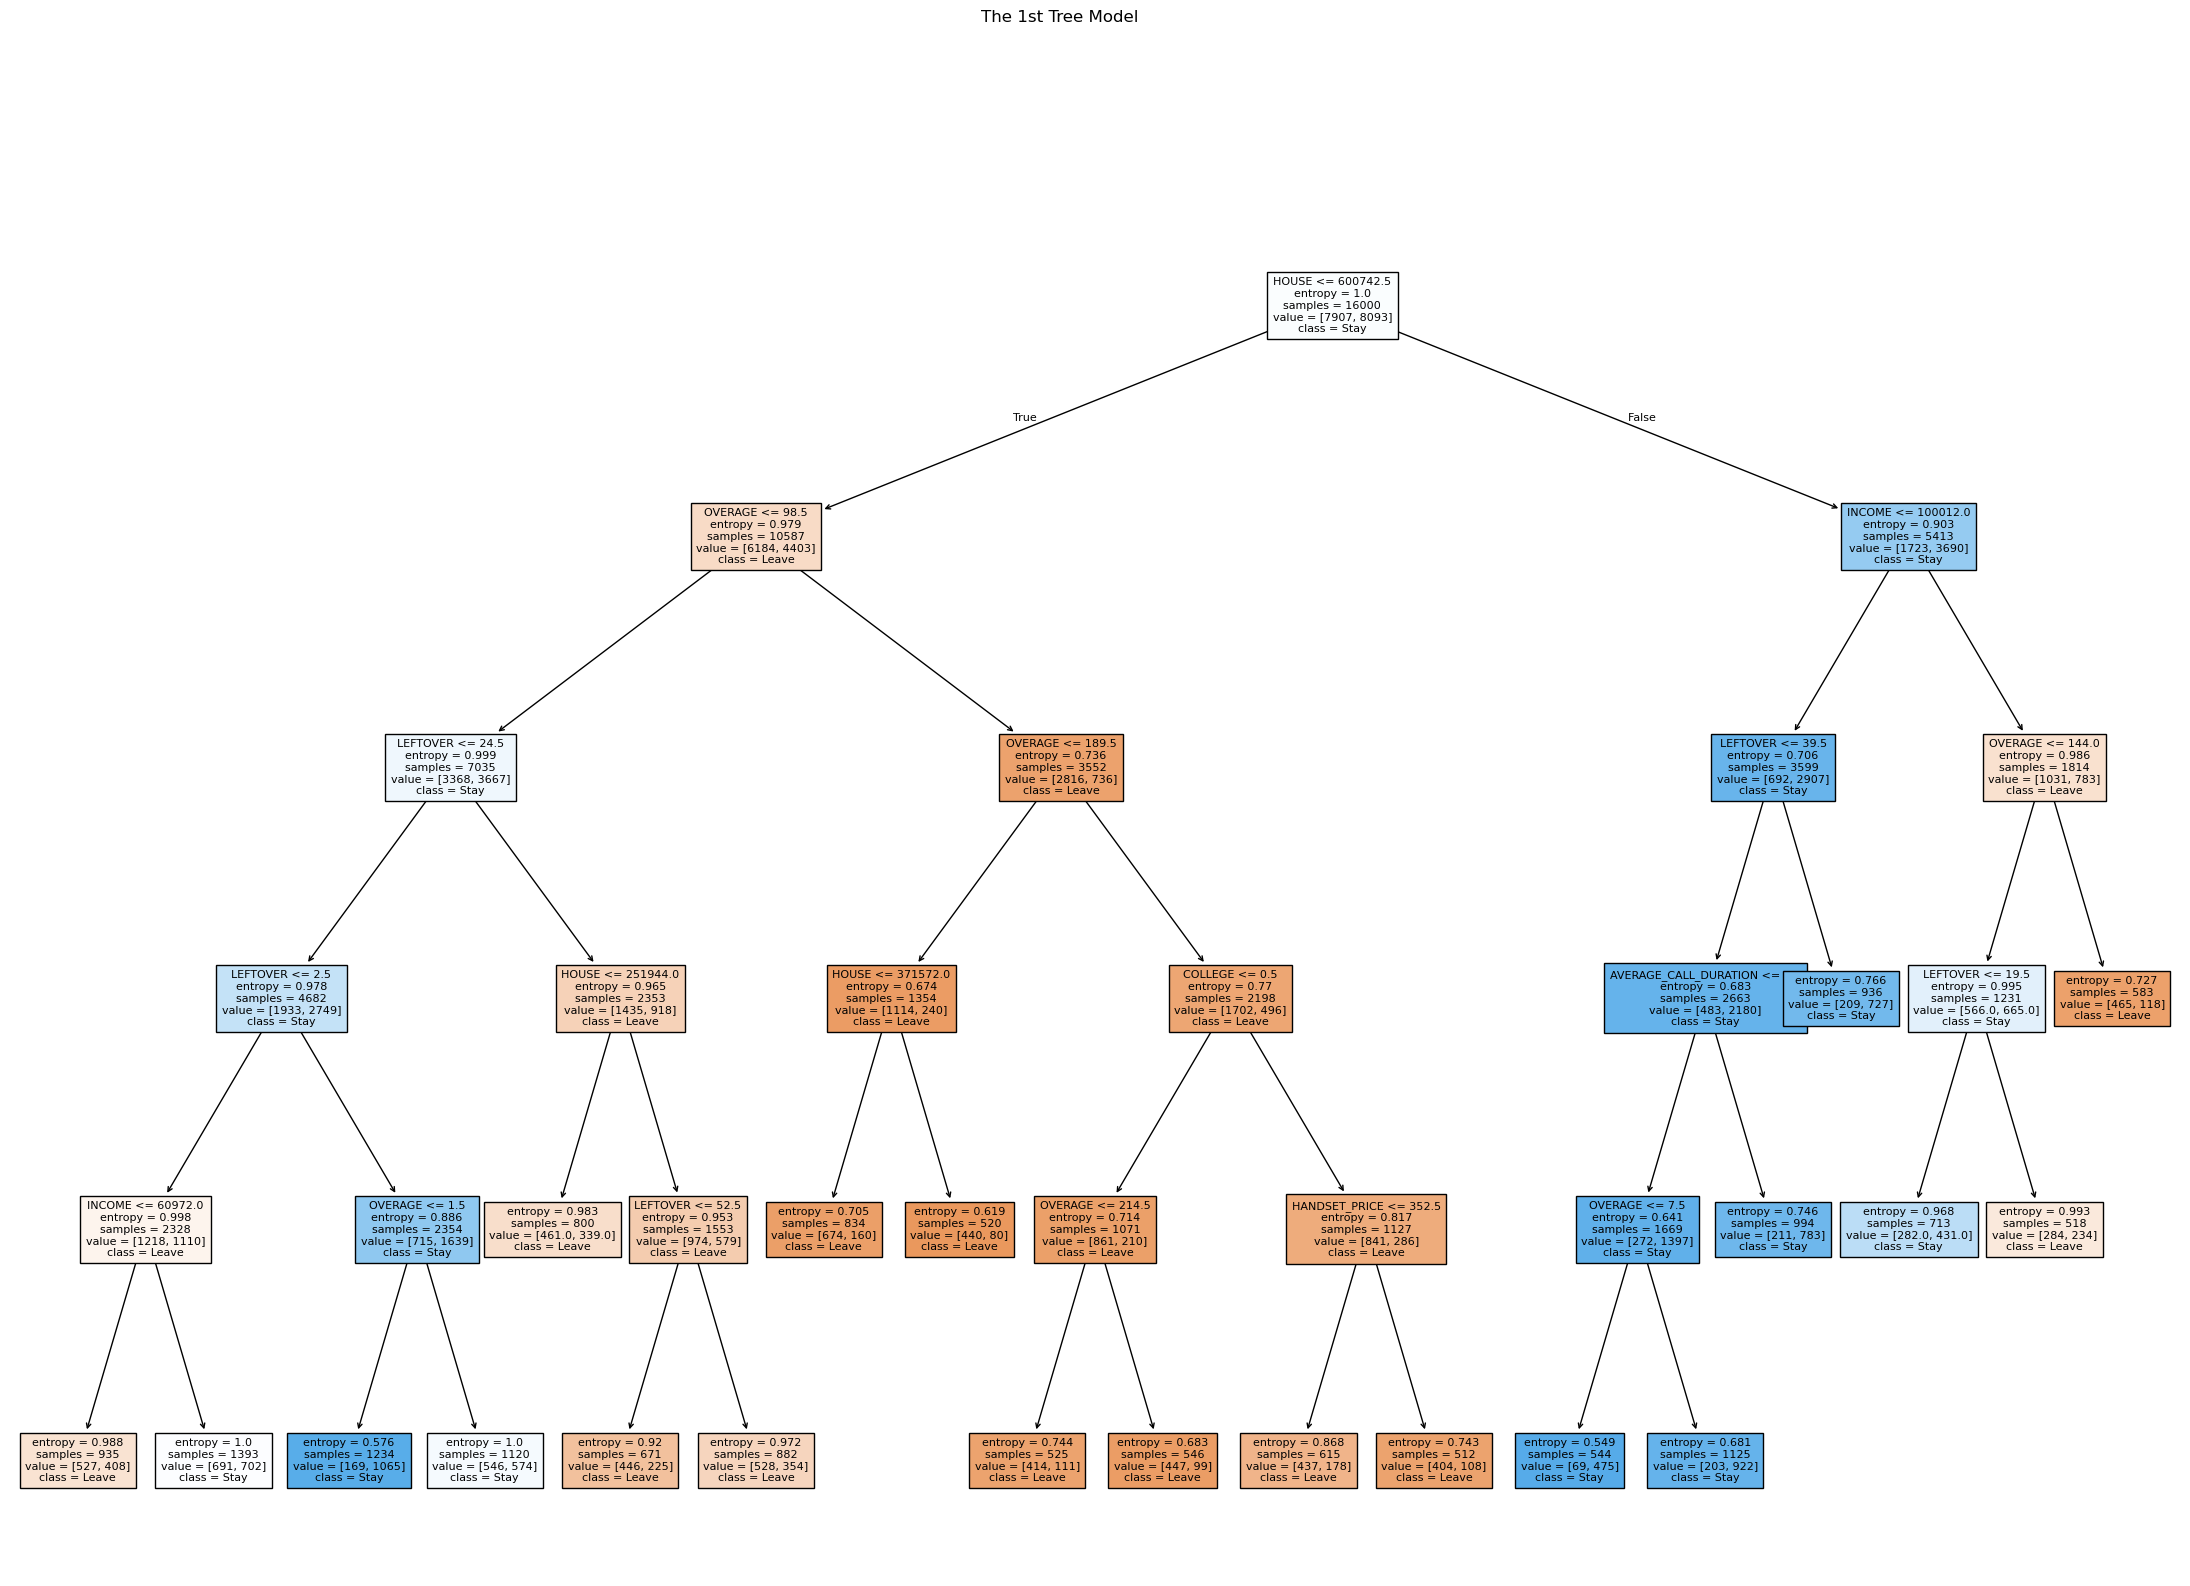

In [36]:
fig = plt.figure(figsize=(28,18))                # create a new figure, specify its width & height in inches.

plot_tree(decision_tree = model1, 
          feature_names = X_train.columns,       # or X_train.columns.to_list() if with an old version of scikit-learn
          class_names = ['Leave','Stay'],        # class labels (corresponding to target values in ascending order)
          filled = True,                         # if True, paint nodes to indicate majority class  
          fontsize = 8)    

fig.suptitle('The 1st Tree Model')               # add a title
plt.show()

**Save the picture in a local folder**  



In [37]:
fig.savefig('my_fig.jpg', dpi = 800)           

<font color=green>***Notes for Google Colab***</font>

for Google Colab users, the above code save the picture in a temp folder on the cloud. To save it in your Google Drive, please make sure (1) you allow the notebook to access Google Drive and then (2) specify the path to the file properly. Check `2.2 Pandas DataFrame` for detailed instruction.

### 2.4 Apply and Evaluate a Model  

**Predict and Evaluate on Train Set**

So far, we've built a model with the training data, let's apply the model to predict on the training data and check the performance.

In [38]:
# Predict the class labels

train_pred = model1.predict(X_train)

train_pred

array(['STAY', 'STAY', 'LEAVE', ..., 'STAY', 'STAY', 'LEAVE'],
      dtype=object)

In [39]:
# Estimate the class probability (classes ordered in alphabetical order: LEAVE, STAY)

model1.predict_proba(X_train)             

array([[0.49605169, 0.50394831],
       [0.49605169, 0.50394831],
       [0.79759863, 0.20240137],
       ...,
       [0.21227364, 0.78772636],
       [0.2232906 , 0.7767094 ],
       [0.79759863, 0.20240137]])

In [40]:
# Model accuracy on train set: how many instances have been predicted correctly? 

accuracy_score(y_train, train_pred)          # alternatively, model1.score(X_train, y_train)

0.700375

**Predict and Evaluate on Test Set** 

After all, model performance on future data is the mostly important. Please complete the following tasks. 

- Apply the model to predict the class labels for test instances. Display the first five predicted labels only.
- Apply the model to estimate the class probability for test instances. Display the first five results only.
- Check the accuracy of the model on the test set. Round the result to 3 decimal places.


<font color=red>***Exercise 2: Your Codes Here***</font>  

In [41]:
test_pred = model1.predict(X_test)

test_pred[:5]              # same as test_pred[0:5]    

array(['LEAVE', 'LEAVE', 'STAY', 'STAY', 'LEAVE'], dtype=object)

In [42]:
test_prob = model1.predict_proba(X_test)

test_prob[:5,:]            # same as test_prob[:5] 

array([[0.80815348, 0.19184652],
       [0.80815348, 0.19184652],
       [0.2232906 , 0.7767094 ],
       [0.4875    , 0.5125    ],
       [0.57625   , 0.42375   ]])

In [43]:
acc = accuracy_score(y_test, test_pred)         # alternatively,   acc = model1.score(X_test, y_test)    

np.round(acc,3)

0.708

In [44]:
print("Finished")

Finished
